[Back to Lecture Overview](Overview.ipynb)

# Database Access
* Author: Johannes Maucher
* Last Update: 02.07.2019
* References: 
    * http://jgardiner.co.uk/blog/read_sql_pandas
    * PostgreSQL Online Manual: [https://www.postgresql.org/docs/8.4/static/queries-table-expressions.html](https://www.postgresql.org/docs/8.4/static/queries-table-expressions.html).
    * SQL Queries in Pandas: http://pandas.pydata.org/pandas-docs/stable/io.html#sql-queries
    * SQLAlchemy documentation: http://docs.sqlalchemy.org/en/latest/intro.html
    * SQLAlchemy tutorial of Python Central: http://pythoncentral.io/introductory-tutorial-python-sqlalchemy/


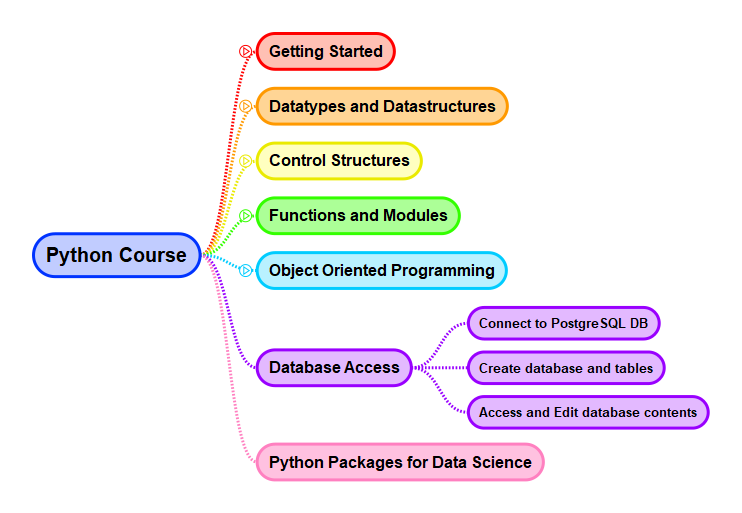

In [1]:
from IPython.display import Image
Image(filename="../../Pics/DS_Python_DataBase_All.png")

## Preliminaries
1. Download and install [PostgreSQL](https://www.postgresql.org/)
2. Verify, that pgAdmin has been installed within the PostgreSQL installation. pgAdmin is an open source administration and development platform for PostgreSQL databases. 
3. In pgAdmin create a new database as described e.g. in https://www.pgadmin.org/docs/pgadmin4/dev/modifying_tables.html.
4. Check if the Python package `psycopg2` is installed. [psycopg2](http://initd.org/psycopg/docs/index.html) is the most popular PostgreSQL database adapter for the Python programming language. For installation type 
`pip install psycopg2`
or
`conda install psycopg2`
into a shell.

In the code below, the name of the database is *dataScienceExp*. Please use your own database- and table-name, instead.

In [2]:
#!conda install -y psycopg2

In [3]:
import psycopg2 #provides drivers for PostgreSQL
import numpy as np
import json #required to access json file
import pandas as pd
from sqlalchemy import create_engine

## Connect to Database
The database-connection parameters are defined in a .json file like this [configTemplate.json](configTemplate.json). Replace the placeholders in this file by the connection-parameters of your database and import your personalized configuration file as follows:

In [6]:
with open('configLocalDS3.json') as f:
    conf = json.load(f)

In [7]:
conf

{'database': 'postgres',
 'host': 'localhost',
 'passw': 'dataScientist',
 'port': '5432',
 'schema': 'schema_name',
 'user': 'postgres'}

The code above reads the contents of the .json-File into a Python dictionary.

In [8]:
print(type(conf))
print("Name of database is: ",conf['database'])
print("Name of user is: ",conf['user'])

<class 'dict'>
Name of database is:  postgres
Name of user is:  postgres


Next, the information from the `conf`-dictionary is integrated in a string-variable `conn_str`, which is passed to the `connect()`-method of `psycopg2`. This method returns a connection-object to the configured database.

In [30]:
conn_str = "host={} dbname={} user={} password={}".format(conf["host"], conf["database"], conf["user"], conf["passw"])
conn = psycopg2.connect(conn_str)
#conn = psycopg2.connect(host=awsDB,dbname="hrv_web",user=awsUser,password=awsPw)

## Without Pandas

The standard Python way to proceed is to generate a `cursor`-object for the connection. This cursor-object can then be used to execute *SQL*-queries:

In [31]:
cur = conn.cursor()

In [32]:
cur.execute("""SELECT * FROM cartable""")

The result of the SQL-query is saved to a Python list by the following command:

In [33]:
rows=cur.fetchall()
print(type(rows))
print(len(rows))

<class 'list'>
32


In [34]:
for a in rows[:3]:
    print(np.array(a))

['0' 'Mazda RX4' '21.0' '6' '160.0' '110' '3.9' '2.62' '16.46' '0' '1' '4'
 '4']
['1' 'Mazda RX4 Wag' '21.0' '6' '160.0' '110' '3.9' '2.875' '17.02' '0'
 '1' '4' '4']
['2' 'Datsun 710' '22.8' '4' '108.0' '93' '3.85' '2.32' '18.61' '1' '1'
 '4' '1']


In [35]:
print(cur.fetchone())

None


In [36]:
cur.execute("""SELECT * FROM cartable""")

In [37]:
print(cur.fetchone())

(0, 'Mazda RX4', 21.0, 6, 160.0, 110, 3.9, 2.62, 16.46, 0, 1, 4, 4)


In [38]:
print(cur.fetchone())

(1, 'Mazda RX4 Wag', 21.0, 6, 160.0, 110, 3.9, 2.875, 17.02, 0, 1, 4, 4)


In [39]:
print(cur.fetchmany(2))

[(2, 'Datsun 710', 22.8, 4, 108.0, 93, 3.85, 2.32, 18.61, 1, 1, 4, 1), (3, 'Hornet 4 Drive', 21.4, 6, 258.0, 110, 3.08, 3.215, 19.44, 1, 0, 3, 1)]


### Create new table and insert some data
The following SQL statement creates a new table, if it not already exists. The table has three columns `id`, `num` and `data`. The first column is a serial number, which acts as primary key, the second column is an integer and the third a string variable. 

In [40]:
cur.execute("CREATE TABLE IF NOT EXISTS test1 (id serial PRIMARY KEY, num integer, data varchar);")

Insert some data into the table:

In [41]:
cur.execute("INSERT INTO test1 (num, data) VALUES (%s, %s)",(100, "first test entry"))

In [42]:
cur.execute("INSERT INTO test1 (num, data) VALUES (%s, %s)",(200, "second test entry"))

Load the entire table:

In [43]:
cur.execute("SELECT * FROM test1;")

In [44]:
print(cur.fetchall())

[(1, 100, 'first test entry'), (2, 200, 'second test entry'), (3, 100, 'first test entry'), (4, 200, 'second test entry'), (5, 100, 'first test entry'), (6, 200, 'second test entry'), (7, 100, 'first test entry'), (8, 200, 'second test entry'), (9, 100, 'first test entry'), (10, 200, 'second test entry'), (11, 100, 'first test entry'), (12, 200, 'second test entry')]


The changes to the databases will only be persistent after the following `commit`-command:

In [45]:
conn.commit()

Close the communication with the database:

In [46]:
#cur.close()
#conn.close()

## Read entire data into Pandas Dataframe

Provided a connection-object, as returned by `psycopg2.connect()`-method, is available, database-data can easily be imported to Pandas dataframes.

In [47]:
df = pd.read_sql('select * from cartable', con=conn)

In [48]:
print(df.shape)

(32, 13)


In [49]:
df

,index,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


In [50]:
conn.close()

## Using SQLAlchemy  and Pandas
The SQLAlchemy SQL Toolkit and Object Relational Mapper (ORM) is a comprehensive set of tools for working with databases and Python ([SQLAlchemy Overview](http://docs.sqlalchemy.org/en/latest/intro.html)). This [SQLAlchemy Tutorial](http://pythoncentral.io/introductory-tutorial-python-sqlalchemy/) provides a glimpse of ORM in SQLAlchemy.

In this lecture, SQLAlchemy is just used because it provides a  comfortable interface with Pandas dataframes. In particular because of its capability to write Pandas dataframe to database tables. 

For accessing a database with SQLAlchemy first an `engine`-object must be created.

In [9]:
from sqlalchemy import create_engine
conn_str ='postgresql://%s:%s@localhost:5432/%s'%(conf["user"], conf["passw"],conf["database"])
engine = create_engine(conn_str)

### Read entire table

The `engine`-object provides the function `connect()` for connecting to the database. This connection can be passed to the `read_sql_table(datatable,connection)`-function of Pandas, which returns a pandas dataframe containing the data of the specified databasetable.

In [10]:
with engine.connect() as conn, conn.begin():
    data = pd.read_sql_table('cartable',conn)

In [11]:
data

,index,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


### SQL-Queries
SQL queries can be realized by writing the SQL statement into a string-variable and passing this string to the Pandas function `read_sql_query()`.

In [12]:
cyl8=pd.read_sql_query("SELECT model,mpg,cyl,carb FROM cartable WHERE cyl = 8 ORDER BY mpg",engine)

In [13]:
cyl8

,model,mpg,cyl,carb
0,Cadillac Fleetwood,10.4,8,4
1,Lincoln Continental,10.4,8,4
2,Camaro Z28,13.3,8,4
3,Duster 360,14.3,8,4
4,Chrysler Imperial,14.7,8,4
5,Maserati Bora,15.0,8,8
6,Merc 450SLC,15.2,8,3
7,AMC Javelin,15.2,8,2
8,Dodge Challenger,15.5,8,2
9,Ford Pantera L,15.8,8,4


### Write Pandas dataframe into database
The following code cells demonstrate how 
* data can be imported from a .csv-file into a Pandas dataframe
* the Pandas dataframe is written into a databasetable.
* if the table not already exists, it will be created first.


#### Insurance Data
Read data from .csv - file into Pandas dataframe:

In [14]:
insuranceDF=pd.read_csv("../../R/Lecture/data/insurance.csv",sep=",",header=0,index_col=False)

In [15]:
insuranceDF.shape

(1338, 7)

In [16]:
insuranceDF.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Write Pandas dataframe into a new table in PostgreSQL DB. 

In [17]:
if not engine.has_table("insurancetable"):
    insuranceDF.to_sql(name='insurancetable',index=True, index_label='index',con=engine)
else:
    print("table already exists")

table already exists


Check if data of the new table can be accessed:

In [18]:
with engine.connect() as conn, conn.begin():
    data = pd.read_sql_table('insurancetable',conn)

In [19]:
data.head()

,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520


In [20]:
child3=pd.read_sql_query("SELECT * FROM insurancetable WHERE children > 3 ORDER BY children",engine)

In [21]:
child3

,index,age,sex,bmi,children,smoker,region,charges
0,344,49,female,41.470,4,no,southeast,10977.20630
1,390,48,male,35.625,4,no,northeast,10736.87075
2,83,48,female,41.230,4,no,northwest,11033.66170
3,165,47,male,28.215,4,no,northeast,10407.08585
4,1012,61,female,33.330,4,no,southeast,36580.28216
5,1064,29,female,25.600,4,no,southwest,5708.86700
6,61,25,male,33.660,4,no,southeast,4504.66240
7,1094,50,female,33.700,4,no,southwest,11299.34300
8,1095,18,female,31.350,4,no,northeast,4561.18850
9,450,39,male,29.600,4,no,southwest,7512.26700


#### Car Data

In [24]:
carsDF=pd.read_csv("../../Data/mtcars.csv",sep=",",header=0,index_col=False)

In [25]:
if not engine.has_table("cartable"):
    carsDF.to_sql(name='cartable',index=True, index_label='index',con=engine)
else:
    print("table already exists")

table already exists


In [26]:
with engine.connect() as conn, conn.begin():
    data = pd.read_sql_table('cartable',conn)

In [27]:
data.head()

,index,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [28]:
carb4=pd.read_sql_query("SELECT * FROM cartable WHERE carb >= 4 ORDER BY mpg",engine)

In [29]:
carb4

,index,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,14,Cadillac Fleetwood,10.4,8,472.0,205,2.93,5.250,17.98,0,0,3,4
1,15,Lincoln Continental,10.4,8,460.0,215,3.00,5.424,17.82,0,0,3,4
2,23,Camaro Z28,13.3,8,350.0,245,3.73,3.840,15.41,0,0,3,4
3,6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
4,16,Chrysler Imperial,14.7,8,440.0,230,3.23,5.345,17.42,0,0,3,4
5,30,Maserati Bora,15.0,8,301.0,335,3.54,3.570,14.60,0,1,5,8
6,28,Ford Pantera L,15.8,8,351.0,264,4.22,3.170,14.50,0,1,5,4
7,10,Merc 280C,17.8,6,167.6,123,3.92,3.440,18.90,1,0,4,4
8,9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4
9,29,Ferrari Dino,19.7,6,145.0,175,3.62,2.770,15.50,0,1,5,6
